In [41]:
from typing import Union, Optional, List, Tuple
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm

from tqdm import tqdm
from sklearn.datasets import make_s_curve
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader

plt.style.use('ggplot')

rainbow5 = cm.get_cmap("rainbow", 5)
rainbow10 = cm.get_cmap("rainbow", 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/tmp/ipykernel_48957/498570934.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rainbow5 = cm.get_cmap("rainbow", 5)
/tmp/ipykernel_48957/498570934.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rainbow10 = cm.get_cmap("rainbow", 10)


## Diffusion
### Forward
$$
x_t = \sqrt{\alpha_t}x_{t-1} + \sqrt{1-\alpha_t}\epsilon
$$
$$
x_t = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1-\bar{\alpha_t}}\epsilon
$$

### Reverse
DDPM 

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \hat{\epsilon}_\theta(x_t, t) \right) + \sigma_t \cdot z 
$$
DDIM 

$$
x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} \left( \frac{x_t - \sqrt{1 - \bar{\alpha}_t} \cdot \hat{\epsilon}_\theta(x_t, t)}{\sqrt{\bar{\alpha}_t}} \right) + \sqrt{1 - \bar{\alpha}_{t-1} - \sigma_t^2} \cdot \hat{\epsilon}_\theta(x_t, t) + \sigma_t \cdot z 
$$

In [26]:

def rescale_zero_terminal_snr(betas: torch.Tensor) -> torch.Tensor:
    """
    Rescales betas to have zero terminal SNR Based on https://arxiv.org/pdf/2305.08891.pdf (Algorithm 1)


    Args:
        betas (`torch.Tensor`):
            the betas that the scheduler is being initialized with.

    Returns:
        `torch.Tensor`: rescaled betas with zero terminal SNR
    """
    # Convert betas to alphas_bar_sqrt
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    alphas_bar_sqrt = alphas_cumprod.sqrt()

    # Store old values.
    alphas_bar_sqrt_0 = alphas_bar_sqrt[0].clone()
    alphas_bar_sqrt_T = alphas_bar_sqrt[-1].clone()

    # Shift so the last timestep is zero.
    alphas_bar_sqrt -= alphas_bar_sqrt_T

    # Scale so the first timestep is back to the old value.
    alphas_bar_sqrt *= alphas_bar_sqrt_0 / (alphas_bar_sqrt_0 - alphas_bar_sqrt_T)

    # Convert alphas_bar_sqrt to betas
    alphas_bar = alphas_bar_sqrt**2  # Revert sqrt
    alphas = alphas_bar[1:] / alphas_bar[:-1]  # Revert cumprod
    alphas = torch.cat([alphas_bar[0:1], alphas])
    betas = 1 - alphas

    return betas

class DDPMScheduler():
    """
    `DDPMScheduler` explores the connections between denoising score matching and Langevin dynamics sampling.

    This model inherits from [`SchedulerMixin`] and [`ConfigMixin`]. Check the superclass documentation for the generic
    methods the library implements for all schedulers such as loading and saving.

    Args:
        num_train_timesteps (`int`, defaults to 1000):
            The number of diffusion steps to train the model.
        beta_start (`float`, defaults to 0.0001):
            The starting `beta` value of inference.
        beta_end (`float`, defaults to 0.02):
            The final `beta` value.
        beta_schedule (`str`, defaults to `"linear"`):
            The beta schedule, a mapping from a beta range to a sequence of betas for stepping the model. Choose from
            `linear`, `scaled_linear`, or `squaredcos_cap_v2`.
        prediction_type (`str`, defaults to `epsilon`, *optional*):
            Prediction type of the scheduler function; can be `epsilon` (predicts the noise of the diffusion process),
            `sample` (directly predicts the noisy sample`) or `v_prediction` (see section 2.4 of [Imagen
            Video](https://imagen.research.google/video/paper.pdf) paper).
        timestep_spacing (`str`, defaults to `"leading"`):
            The way the timesteps should be scaled. Refer to Table 2 of the [Common Diffusion Noise Schedules and
            Sample Steps are Flawed](https://huggingface.co/papers/2305.08891) for more information.
        steps_offset (`int`, defaults to 0):
            An offset added to the inference steps, as required by some model families.
        rescale_betas_zero_snr (`bool`, defaults to `False`):
            Whether to rescale the betas to have zero terminal SNR. This enables the model to generate very bright and
            dark samples instead of limiting it to samples with medium brightness. Loosely related to
            [`--offset_noise`](https://github.com/huggingface/diffusers/blob/74fd735eb073eb1d774b1ab4154a0876eb82f055/examples/dreambooth/train_dreambooth.py#L506).
    """

    def __init__(
        self,
        num_train_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
        beta_schedule: str = "linear",
        variance_type: str = "fixed_small",
        prediction_type: str = "epsilon",
        timestep_spacing: str = "leading",
        steps_offset: int = 0,
        rescale_betas_zero_snr: bool = False,
    ):
        self.num_train_timesteps = num_train_timesteps
        self.prediction_type = prediction_type
        self.timestep_spacing = timestep_spacing
        self.steps_offset = steps_offset
        if beta_schedule == "linear":
            self.betas = torch.linspace(beta_start, beta_end, num_train_timesteps, dtype=torch.float32)
        elif beta_schedule == "scaled_linear":
            # this schedule is very specific to the latent diffusion model.
            self.betas = torch.linspace(beta_start**0.5, beta_end**0.5, num_train_timesteps, dtype=torch.float32) ** 2
        elif beta_schedule == "sigmoid":
            # GeoDiff sigmoid schedule
            betas = torch.linspace(-6, 6, num_train_timesteps)
            self.betas = torch.sigmoid(betas) * (beta_end - beta_start) + beta_start
        else:
            raise NotImplementedError(f"{beta_schedule} is not implemented for {self.__class__}")

        # Rescale for zero SNR
        if rescale_betas_zero_snr:
            self.betas = rescale_zero_terminal_snr(self.betas)

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.one = torch.tensor(1.0)

        # standard deviation of the initial noise distribution
        self.init_noise_sigma = 1.0

        # setable values
        self.num_inference_steps = None
        self.custom_timesteps = False
        self.timesteps = torch.from_numpy(np.arange(0, num_train_timesteps)[::-1].copy())

        self.variance_type = variance_type

    def set_timesteps(
        self,
        num_inference_steps: int,
        device: Union[str, torch.device] = None,
        timesteps: Optional[List[int]] = None,
    ):
        """
        Sets the discrete timesteps used for the diffusion chain (to be run before inference).

        Args:
            num_inference_steps (`int`):
                The number of diffusion steps used when generating samples with a pre-trained model. If used,
                `timesteps` must be `None`.
            device (`str` or `torch.device`, *optional*):
                The device to which the timesteps should be moved to. If `None`, the timesteps are not moved.
            timesteps (`List[int]`, *optional*):
                Custom timesteps used to support arbitrary spacing between timesteps. If `None`, then the default
                timestep spacing strategy of equal spacing between timesteps is used. If `timesteps` is passed,
                `num_inference_steps` must be `None`.

        """
        if timesteps is not None:
            for i in range(1, len(timesteps)):
                if timesteps[i] >= timesteps[i - 1]:
                    raise ValueError("`custom_timesteps` must be in descending order.")

            if timesteps[0] >= self.num_train_timesteps:
                raise ValueError(
                    f"`timesteps` must start before `self.config.train_timesteps`:"
                    f" {self.num_train_timesteps}."
                )

            timesteps = np.array(timesteps, dtype=np.int64)
            self.custom_timesteps = True
        else:
            if num_inference_steps > self.num_train_timesteps:
                raise ValueError(
                    f"`num_inference_steps`: {num_inference_steps} cannot be larger than `self.config.train_timesteps`:"
                    f" {self.num_train_timesteps} as the unet model trained with this scheduler can only handle"
                    f" maximal {self.num_train_timesteps} timesteps."
                )

            self.num_inference_steps = num_inference_steps
            self.custom_timesteps = False

            # "linspace", "leading", "trailing" corresponds to annotation of Table 2. of https://arxiv.org/abs/2305.08891
            if self.timestep_spacing == "linspace":
                timesteps = (
                    np.linspace(0, self.num_train_timesteps - 1, num_inference_steps).round()[::-1]
                    .copy().astype(np.int64)
                )
            elif self.timestep_spacing == "leading":
                step_ratio = self.num_train_timesteps // self.num_inference_steps
                # creates integer timesteps by multiplying by ratio
                # casting to int to avoid issues when num_inference_step is power of 3
                timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
                timesteps += self.steps_offset
            elif self.timestep_spacing == "trailing":
                step_ratio = self.num_train_timesteps / self.num_inference_steps
                # creates integer timesteps by multiplying by ratio
                # casting to int to avoid issues when num_inference_step is power of 3
                timesteps = np.round(np.arange(self.num_train_timesteps, 0, -step_ratio)).astype(np.int64)
                timesteps -= 1
            else:
                raise ValueError(
                    f"{self.timestep_spacing} is not supported. Please make sure to choose one of 'linspace', 'leading' or 'trailing'."
                )

        self.timesteps = torch.from_numpy(timesteps).to(device)

    def _get_variance(self, t, predicted_variance=None, variance_type=None):
        prev_t = self.previous_timestep(t)

        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        current_beta_t = 1 - alpha_prod_t / alpha_prod_t_prev

        # For t > 0, compute predicted variance βt (see formula (6) and (7) from https://arxiv.org/pdf/2006.11239.pdf)
        # and sample from it to get previous sample
        # x_{t-1} ~ N(pred_prev_sample, variance) == add variance to pred_sample
        variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t

        # we always take the log of variance, so clamp it to ensure it's not 0
        variance = torch.clamp(variance, min=1e-20)

        if variance_type is None:
            variance_type = self.variance_type

        # hacks - were probably added for training stability
        if variance_type == "fixed_small":
            variance = variance
        # for rl-diffuser https://arxiv.org/abs/2205.09991
        elif variance_type == "fixed_small_log":
            variance = torch.log(variance)
            variance = torch.exp(0.5 * variance)
        elif variance_type == "fixed_large":
            variance = current_beta_t
        elif variance_type == "fixed_large_log":
            # Glide max_log
            variance = torch.log(current_beta_t)
        elif variance_type == "learned":
            return predicted_variance
        elif variance_type == "learned_range":
            min_log = torch.log(variance)
            max_log = torch.log(current_beta_t)
            frac = (predicted_variance + 1) / 2
            variance = frac * max_log + (1 - frac) * min_log

        return variance

    def step(
        self,
        model_output: torch.Tensor,
        timestep: int,
        sample: torch.Tensor,
        generator=None,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Predict the sample from the previous timestep by reversing the SDE. This function propagates the diffusion
        process from the learned model outputs (most often the predicted noise).

        Args:
            model_output (`torch.Tensor`):
                The direct output from learned diffusion model.
            timestep (`float`):
                The current discrete timestep in the diffusion chain.
            sample (`torch.Tensor`):
                A current instance of a sample created by the diffusion process.
            generator (`torch.Generator`, *optional*):
                A random number generator.

        Returns:
            `tuple`:
                a tuple is returned where the first element is the sample tensor.

        """
        t = timestep

        prev_t = self.previous_timestep(t)

        if model_output.shape[1] == sample.shape[1] * 2 and self.variance_type in ["learned", "learned_range"]:
            model_output, predicted_variance = torch.split(model_output, sample.shape[1], dim=1)
        else:
            predicted_variance = None

        # 1. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        current_alpha_t = alpha_prod_t / alpha_prod_t_prev
        current_beta_t = 1 - current_alpha_t

        # 2. compute predicted original sample from predicted noise also called
        # "predicted x_0" of formula (15) from https://arxiv.org/pdf/2006.11239.pdf
        if self.prediction_type == "epsilon":
            pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
        elif self.prediction_type == "sample":
            pred_original_sample = model_output
        elif self.prediction_type == "v_prediction":
            pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
        else:
            raise ValueError(
                f"prediction_type given as {self.prediction_type} must be one of `epsilon`, `sample` or"
                " `v_prediction`  for the DDPMScheduler."
            )

        # 4. Compute coefficients for pred_original_sample x_0 and current sample x_t
        # See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
        pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
        current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t

        # 5. Compute predicted previous sample µ_t
        # See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
        pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * sample

        # 6. Add noise
        variance = 0
        if t > 0:
            device = model_output.device
            variance_noise = torch.randn(model_output.shape, generator=generator, device=device, dtype=model_output.dtype)
            if self.variance_type == "fixed_small_log":
                variance = self._get_variance(t, predicted_variance=predicted_variance) * variance_noise
            elif self.variance_type == "learned_range":
                variance = self._get_variance(t, predicted_variance=predicted_variance)
                variance = torch.exp(0.5 * variance) * variance_noise
            else:
                variance = (self._get_variance(t, predicted_variance=predicted_variance) ** 0.5) * variance_noise
        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample, pred_original_sample

    def add_noise(
        self,
        original_samples: torch.Tensor,
        noise: torch.Tensor,
        timesteps: torch.IntTensor,
    ) -> torch.Tensor:
        # x_t = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1-\bar{\alpha_t}} \epsilon
        # Make sure alphas_cumprod and timestep have same device and dtype as original_samples
        # Move the self.alphas_cumprod to device to avoid redundant CPU to GPU data movement
        # for the subsequent add_noise calls
        self.alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device)
        alphas_cumprod = self.alphas_cumprod.to(dtype=original_samples.dtype)
        timesteps = timesteps.to(original_samples.device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while sqrt_alpha_prod.ndim < original_samples.ndim:
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while sqrt_one_minus_alpha_prod.ndim < original_samples.ndim:
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        return noisy_samples

    def get_velocity(self, sample: torch.Tensor, noise: torch.Tensor, timesteps: torch.IntTensor) -> torch.Tensor:
        # Make sure alphas_cumprod and timestep have same device and dtype as sample
        self.alphas_cumprod = self.alphas_cumprod.to(device=sample.device)
        alphas_cumprod = self.alphas_cumprod.to(dtype=sample.dtype)
        timesteps = timesteps.to(sample.device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while len(sqrt_alpha_prod.shape) < len(sample.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while len(sqrt_one_minus_alpha_prod.shape) < len(sample.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        velocity = sqrt_alpha_prod * noise - sqrt_one_minus_alpha_prod * sample
        return velocity

    def __len__(self):
        return self.num_train_timesteps

    def previous_timestep(self, timestep):
        if self.custom_timesteps:
            index = (self.timesteps == timestep).nonzero(as_tuple=True)[0][0]
            if index == self.timesteps.shape[0] - 1:
                prev_t = torch.tensor(-1)
            else:
                prev_t = self.timesteps[index + 1]
        else:
            num_inference_steps = (
                self.num_inference_steps if self.num_inference_steps else self.num_train_timesteps
            )
            prev_t = timestep - self.num_train_timesteps // num_inference_steps

        return prev_t

In [77]:
class DDIMScheduler(DDPMScheduler):

    def __init__(
        self,
        num_train_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
        beta_schedule: str = "linear",
        variance_type: str = "fixed_small",
        prediction_type: str = "epsilon",
        timestep_spacing: str = "leading",
        steps_offset: int = 0,
        rescale_betas_zero_snr: bool = False,
        set_alpha_to_one: bool = False
    ):

        super().__init__(
            num_train_timesteps,
            beta_start,
            beta_end,
            beta_schedule,
            variance_type,
            prediction_type,
            timestep_spacing,
            steps_offset,
            rescale_betas_zero_snr,
        )
        # At every step in ddim, we are looking into the previous alphas_cumprod
        # For the final step, there is no previous alphas_cumprod because we are already at 0
        # `set_alpha_to_one` decides whether we set this parameter simply to one or
        # whether we use the final alpha of the "non-previous" one.
        self.final_alpha_cumprod = torch.tensor(1.0) if set_alpha_to_one else self.alphas_cumprod[0]

        # standard deviation of the initial noise distribution
        self.init_noise_sigma = 1.0
    def step(
        self,
        model_output: torch.Tensor,
        timestep: int,
        sample: torch.Tensor,
        eta: float = 0.0,
        use_clipped_model_output: bool = False,
        generator=None,
        variance_noise: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Predict the sample from the previous timestep by reversing the SDE. This function propagates the diffusion
        process from the learned model outputs (most often the predicted noise).

        Args:
            model_output (`torch.Tensor`):
                The direct output from learned diffusion model.
            timestep (`float`):
                The current discrete timestep in the diffusion chain.
            sample (`torch.Tensor`):
                A current instance of a sample created by the diffusion process.
            eta (`float`):
                The weight of noise for added noise in diffusion step.
            use_clipped_model_output (`bool`, defaults to `False`):
                If `True`, computes "corrected" `model_output` from the clipped predicted original sample. Necessary
                because predicted original sample is clipped to [-1, 1] when `self.config.clip_sample` is `True`. If no
                clipping has happened, "corrected" `model_output` would coincide with the one provided as input and
                `use_clipped_model_output` has no effect.
            generator (`torch.Generator`, *optional*):
                A random number generator.
            variance_noise (`torch.Tensor`):
                Alternative to generating noise with `generator` by directly providing the noise for the variance
                itself. Useful for methods such as [`CycleDiffusion`].
        Returns:
            [`~schedulers.scheduling_ddim.DDIMSchedulerOutput`] or `tuple`:
                If return_dict is `True`, [`~schedulers.scheduling_ddim.DDIMSchedulerOutput`] is returned, otherwise a
                tuple is returned where the first element is the sample tensor.

        """
        if self.num_inference_steps is None:
            raise ValueError(
                "Number of inference steps is 'None', you need to run 'set_timesteps' after creating the scheduler"
            )

        # See formulas (12) and (16) of DDIM paper https://arxiv.org/pdf/2010.02502.pdf
        # Ideally, read DDIM paper in-detail understanding

        # Notation (<variable name> -> <name in paper>
        # - pred_noise_t -> e_theta(x_t, t)
        # - pred_original_sample -> f_theta(x_t, t) or x_0
        # - std_dev_t -> sigma_t
        # - eta -> η
        # - pred_sample_direction -> "direction pointing to x_t"
        # - pred_prev_sample -> "x_t-1"

        # 1. get previous step value (=t-1)
        prev_timestep = timestep - self.num_train_timesteps // self.num_inference_steps

        # 2. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.final_alpha_cumprod

        beta_prod_t = 1 - alpha_prod_t

        # 3. compute predicted original sample from predicted noise also called
        # "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        if self.prediction_type == "epsilon":
            pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
            pred_epsilon = model_output
        elif self.prediction_type == "sample":
            pred_original_sample = model_output
            pred_epsilon = (sample - alpha_prod_t ** (0.5) * pred_original_sample) / beta_prod_t ** (0.5)
        elif self.prediction_type == "v_prediction":
            pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
            pred_epsilon = (alpha_prod_t**0.5) * model_output + (beta_prod_t**0.5) * sample
        else:
            raise ValueError(
                f"prediction_type given as {self.prediction_type} must be one of `epsilon`, `sample`, or"
                " `v_prediction`"
            )

        # 5. compute variance: "sigma_t(η)" -> see formula (16)
        # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
        variance = self._get_variance(timestep, prev_timestep)
        std_dev_t = eta * variance ** (0.5)

        if use_clipped_model_output:
            # the pred_epsilon is always re-derived from the clipped x_0 in Glide
            pred_epsilon = (sample - alpha_prod_t ** (0.5) * pred_original_sample) / beta_prod_t ** (0.5)

        # 6. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2) ** (0.5) * pred_epsilon

        # 7. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction

        if eta > 0:
            if variance_noise is not None and generator is not None:
                raise ValueError(
                    "Cannot pass both generator and variance_noise. Please make sure that either `generator` or"
                    " `variance_noise` stays `None`."
                )
            if variance_noise is None:
                variance_noise = torch.randn(model_output.shape, generator=generator, device=model_output.device, dtype=model_output.dtype)
            variance = std_dev_t * variance_noise

            prev_sample = prev_sample + variance


        return prev_sample, pred_original_sample


In [28]:
scheduler = DDIMScheduler(
    num_train_timesteps = 1000,
    beta_end = 0.012,
    beta_start = 0.00085,
    beta_schedule = "scaled_linear",
    steps_offset = 1,
)
scheduler.set_timesteps(50)
x = torch.rand(4, 3)
noise = torch.randn(4, 3)
t = torch.randint(0, 1000, (4, ))
x_t = scheduler.add_noise(x, noise, t)
print(x_t.shape)
print(scheduler.step(noise, 32, x_t)[0].shape)

torch.Size([4, 3])
torch.Size([4, 3])


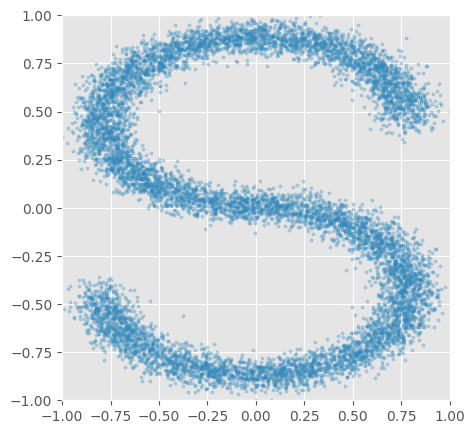

In [31]:
num_samples = int(1e4)
scaler = MinMaxScaler()

s_curve, _ = make_s_curve(num_samples, noise = 0.1, random_state = 42)
s_curve = s_curve[:, [0, 2]]
scaler = MinMaxScaler(feature_range=(-1.0, 1.0))
s_curve = scaler.fit_transform(s_curve)

plt.figure(figsize=(5, 5))
plt.scatter(*s_curve.T, c='C1', alpha=0.3, s=5)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [62]:
class MLP(nn.Module):
    def __init__(self, n_steps, features: int = 2, hidden_size: int = 128):
        super(MLP,self).__init__()

        self.linears = nn.ModuleList([
            nn.Linear(features,  hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
        ])
        self.step_embeddings = nn.ModuleList([
            nn.Embedding(n_steps, hidden_size),
            nn.Embedding(n_steps, hidden_size),
            nn.Embedding(n_steps, hidden_size),
        ])

        self.fc = nn.Linear(hidden_size, features)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        for linear, embedding in zip(self.linears, self.step_embeddings):
            x = F.relu(linear(x) + embedding(t))
        x = self.fc(x)
        return x

In [91]:
# dataset = torch.Tensor(s_curve).float()
num_epoch = 1000
batch_size = 128
dataset = TensorDataset(torch.Tensor(s_curve).float())
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

scheduler = DDPMScheduler(
    num_train_timesteps = 1000,
    beta_end = 0.5e-2,
    beta_start = 1e-5,
    beta_schedule = "sigmoid",
    steps_offset = 0,
)
model = MLP(scheduler.num_train_timesteps)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses = []
with tqdm(range(num_epoch), total=num_epoch, desc="Train") as pbar:
    for epoch in pbar:
        total_loss = 0.0
        for (samples, ) in dataloader:
            samples: torch.Tensor = samples.to(device)
            noise = torch.randn_like(samples)
            t = torch.randint(0, scheduler.num_train_timesteps, size=(samples.size(0), ), device=device)
            samples_t = scheduler.add_noise(samples, noise, t)
            output: torch.Tensor = model(samples_t, t)
            loss: torch.Tensor = F.mse_loss(output, noise)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.)
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss/len(dataloader)
        pbar.set_postfix({"loss": avg_loss})
        losses.append(avg_loss)


Train: 100%|██████████| 1000/1000 [04:37<00:00,  3.60it/s, loss=0.43]


In [106]:
scheduler = DDIMScheduler(
    num_train_timesteps = 1000,
    beta_end = 0.5e-2,
    beta_start = 1e-5,
    beta_schedule = "sigmoid",
    steps_offset = 0,
)

num_inference_steps = 5

scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = scheduler.timesteps
print(timesteps)
noise = torch.randn(1000, 2).to(device)
with torch.no_grad():
    x = noise
    for i, t in tqdm(enumerate(timesteps)):
        output = model(x, t)
        # compute the previous noisy sample x_t -> x_t-1
        x = scheduler.step(output, t, x)[0]
    print(x.shape)



tensor([800, 600, 400, 200,   0], device='cuda:0')


5it [00:00, 776.55it/s]

torch.Size([1000, 2])


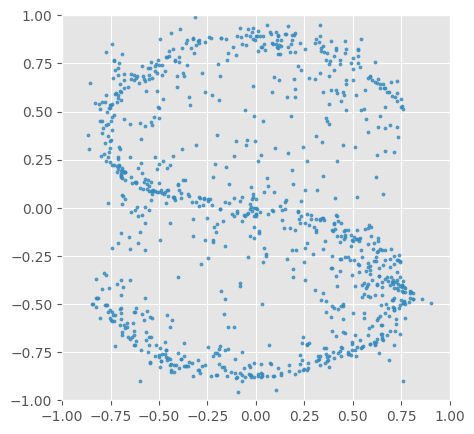

In [107]:
plt.figure(figsize=(5, 5))
plt.scatter(*x.cpu().numpy().T, c='C1', alpha=0.8, s=5)
# plt.scatter(*noise.cpu().numpy().T, c='C0', alpha=0.8, s=5)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()